# Random Forest trong Python

- Nguyễn Hữu Vũ  
- Nhóm nghiên cứu về AI đại học Bách Khoa Tp. Hồ Chí Minh

#### Trong bài này chúng ta làm việc với tập dữ liệu Titanic:
- Titanic_train.csv: data and labels
- Titanic_test.csv: only data

#### Mục tiêu:
- Hiểu được cách xử lí dữ liệu
- Áp dụng mô hình Decision Tree để phân loại dữ liệu

https://www.kaggle.com/c/titanic/data

##### Đặc tả dataset:
- Survived: Survived (1) or died (0)
- Pclass: Passenger’s class
- Name: Passenger’s name
- Sex: Passenger’s sex
- Age: Passenger’s age
- SibSp: Number of siblings/spouses aboard
- Parch: Number of parents/children aboard
- Ticket: Ticket number
- Fare: Fare
- Cabin: Cabin
- Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)



In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('Titanic_train.csv')
test = pd.read_csv('Titanic_test.csv')

## 1) Khám phá dữ liệu

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.describe(include=['object', 'bool'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,1601,B96 B98,S
freq,1,577,7,4,644


## 2) Phân tích ý nghĩa các `features`

### Survived


In [6]:
train['Survived'].value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


- 62% người chết, chỉ có 38% sống sót

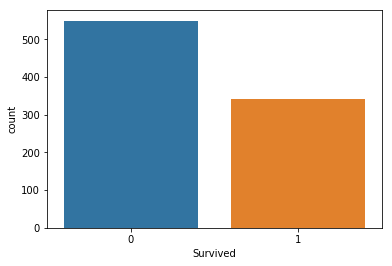

In [7]:
sns.countplot(train['Survived'])

### Pclass


In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# kiểm tra tỉ lệ  Survied dựa trên Pclass
train['Survived'].groupby(train['Pclass']).mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [9]:
sns.countplot(train['Pclass'], hue=train['Survived'])

ValueError: The following variable cannot be assigned with wide-form data: `hue`

- Chúng ta thấy `Pclass` có vai trò quan trọng trong việc sống sót của một người, những người có `Pclass` càng cao (1> 2>3) thì tỉ lệ sống sót càng cao

### Name  

- Cột `Name` hiện tại không cung cấp được nhiều thông tin, do đó chúng ta sẽ cố gắng extract thông tin từ cột này

In [11]:
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [12]:
train['Name_Title'] = train['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
train['Name_Title'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Mlle.          2
Major.         2
Mme.           1
Lady.          1
Sir.           1
Don.           1
Ms.            1
the            1
Jonkheer.      1
Capt.          1
Name: Name_Title, dtype: int64

In [13]:

train['Name_Title'].value_counts(normalize = True)

Mr.          0.580247
Miss.        0.204265
Mrs.         0.140292
Master.      0.044893
Dr.          0.007856
Rev.         0.006734
Col.         0.002245
Mlle.        0.002245
Major.       0.002245
Mme.         0.001122
Lady.        0.001122
Sir.         0.001122
Don.         0.001122
Ms.          0.001122
the          0.001122
Jonkheer.    0.001122
Capt.        0.001122
Name: Name_Title, dtype: float64

In [14]:
train['Survived'].groupby(train['Name_Title']).mean()

Name_Title
Capt.        0.000000
Col.         0.500000
Don.         0.000000
Dr.          0.428571
Jonkheer.    0.000000
Lady.        1.000000
Major.       0.500000
Master.      0.575000
Miss.        0.697802
Mlle.        1.000000
Mme.         1.000000
Mr.          0.156673
Mrs.         0.792000
Ms.          1.000000
Rev.         0.000000
Sir.         1.000000
the          1.000000
Name: Survived, dtype: float64

- Có mối liên hệ giữa `Name_Title` và `Survived`

### Sex

"Women and children first", do đó chúng ta kì vòng `Female` sẽ có tỉ lệ sống sót cao hơn

In [15]:

train['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

- 64.7% male, 35.2% female

In [16]:
train['Survived'].groupby(train['Sex']).mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

- Tỉ lệ `Survived` của `female` là 74%, trong khi `male` chỉ là 18.8%

### Age



In [17]:
train['Age'].head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

In [18]:
train['Age'].isnull().sum()

177

- 177 nulls cho cột `Age`

In [19]:
train['Survived'].groupby(train['Age'].isnull()).mean()

Age
False    0.406162
True     0.293785
Name: Survived, dtype: float64

### SibSp  



In [20]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [21]:
train['Survived'].groupby(train['SibSp']).mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

- Tỉ lệ sót của người có 8 `SibSp` là 0%
- Tỉ lệ sót của người có 1 `SibSp` là 53.5%

## Parch



In [22]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [23]:
train['Survived'].groupby(train['Parch']).mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

- Nhận xét tương tự `Sibsp`

- Có thể combine `SibSp` and `Parch` thành `FamilySize`

### Ticket  



In [24]:
train['Ticket'].head(n=10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

One piece of potentially useful informatin is the number of characters in the `Ticket` column. This could be a reflection of the 'type' of ticket a given passenger had, which could somehow indicate their chances of survival.

In [25]:
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))

In [26]:
train['Ticket_Len'].value_counts()

6     419
5     131
4     101
8      76
10     41
7      27
9      26
17     14
16     11
13     10
12     10
15      9
11      8
18      6
3       2
Name: Ticket_Len, dtype: int64

Another piece of information is the first letter of each ticket, which, again, might be indicative of a certain attribute of the ticketholders or their rooms.

In [27]:
train['Ticket_Lett'] = train['Ticket'].apply(lambda x: str(x)[0])

In [28]:
train['Ticket_Lett']

0      A
1      P
2      S
3      1
4      3
5      3
6      1
7      3
8      3
9      2
10     P
11     1
12     A
13     3
14     3
15     2
16     3
17     2
18     3
19     2
20     2
21     2
22     3
23     1
24     3
25     3
26     2
27     1
28     3
29     3
      ..
861    2
862    1
863    C
864    2
865    2
866    S
867    P
868    3
869    3
870    3
871    1
872    6
873    3
874    P
875    2
876    7
877    3
878    3
879    1
880    2
881    3
882    7
883    C
884    S
885    3
886    2
887    1
888    W
889    1
890    3
Name: Ticket_Lett, Length: 891, dtype: object

In [29]:
train['Ticket_Lett'].value_counts()

3    301
2    183
1    146
P     65
S     65
C     47
A     29
W     13
4     10
7      9
F      7
6      6
L      4
5      3
8      2
9      1
Name: Ticket_Lett, dtype: int64

In [30]:
train.groupby(['Ticket_Lett'])['Survived'].mean()

Ticket_Lett
1    0.630137
2    0.464481
3    0.239203
4    0.200000
5    0.000000
6    0.166667
7    0.111111
8    0.000000
9    1.000000
A    0.068966
C    0.340426
F    0.571429
L    0.250000
P    0.646154
S    0.323077
W    0.153846
Name: Survived, dtype: float64

### Tương tự, các bạn phân tích các `features` còn lại để hiểu ý nghĩa, mối liên vệ với `Survived`

## 3) Xử lí dữ liệu

Sau khi phân tích dữ liệu, xác định ý nghĩa các `features`,  chúng ta sẽ xử lí dữ liệu, tạo ra các `features` mới, quyết định xem nên dùng hay bỏ `features` nào trong khi xây dựng models. Có nhiều cách để  xây dựng bộ `features` cho models, dưới đây chỉ là một trong số đó, giống với cách đã sử dụng trong bài Labs về Decision Tree:

In [31]:
# Loading the data
train = pd.read_csv('Titanic_train.csv')
test = pd.read_csv('Titanic_test.csv')
full_data = [train, test]

In [32]:
#kiểm tra xem sao khi xử lí thống kê thay đổi gì không
pd.isnull(train).any() | pd.isnull(test).any()

Age             True
Cabin           True
Embarked        True
Fare            True
Name           False
Parch          False
PassengerId    False
Pclass         False
Sex            False
SibSp          False
Survived       False
Ticket         False
dtype: bool

In [33]:

# Fill "S" for null values in  the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Fill values for  NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())


In [34]:
#Xử lí missing data cho cột "Age"
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

In [35]:
pd.isnull(train).any() | pd.isnull(test).any()

Age            False
Cabin           True
Embarked       False
Fare           False
Name           False
Parch          False
PassengerId    False
Pclass         False
Sex            False
SibSp          False
Survived       False
Ticket         False
dtype: bool

In [36]:
import re

In [37]:
# Add values for NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [38]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,4
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,1


### Loại bỏ những features không cần thiết

In [39]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [40]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Title
0,0,3,1,1,0,0,0,1
1,1,1,0,2,0,3,1,3
2,1,3,0,1,0,1,0,4
3,1,1,0,2,0,3,0,3
4,0,3,1,2,0,1,0,1


## 3) Sử dụng RandomForest

In [41]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Title
0,0,3,1,1,0,0,0,1
1,1,1,0,2,0,3,1,3
2,1,3,0,1,0,1,0,4
3,1,1,0,2,0,3,0,3
4,0,3,1,2,0,1,0,1


In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train.drop(['Survived'], axis=1), train['Survived'])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [43]:
y_pred = rf.predict(test)
y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## Bài tập:

- Hãy phân tích và  xây dựng các bộ  `features` mới và sử dụng để xây dựng model, so sánh kết quả với model phía trên.
- Hãy chia  thành 2 phần: `train` và `test` và thử kết quả, so sánh độ chính xác